In [9]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
data = pd.read_csv(r"D:\回归数据\allpi3k分子描述符内部数据集.csv")  # 确保CSV文件包含描述符列和pIC50列
# 将inf替换为NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)
# 删除包含NaN的行（你也可以选择填充数据，如：data.fillna(data.mean(), inplace=True)）
data.dropna(inplace=True)

# 确保CSV文件包含描述符列和pIC50列
descriptors = data.drop(columns=['pIC50', 'smiles'])
pIC50 = data["pIC50"]

# 2. 计算 Pearson 相关系数并筛选高相关性特征
corr_threshold = 0.2  # 设定相关性阈值
correlations = {col: pearsonr(descriptors[col], pIC50)[0] for col in descriptors.columns}
selected_features = [col for col, corr in correlations.items() if abs(corr) >= corr_threshold]
filtered_data = descriptors[selected_features]

C:\Users\RANSHAO\AppData\Local\Temp\ipykernel_18776\3098522660.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = {col: pearsonr(descriptors[col], pIC50)[0] for col in descriptors.columns}


In [11]:

# 2. 计算 Pearson 相关系数并筛选高相关性特征
corr_threshold = 0.2  # 设定相关性阈值
correlations = {col: pearsonr(descriptors[col], pIC50)[0] for col in descriptors.columns}
selected_features = [col for col, corr in correlations.items() if abs(corr) >= corr_threshold]
filtered_data = descriptors[selected_features]

C:\Users\RANSHAO\AppData\Local\Temp\ipykernel_18776\4017026010.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = {col: pearsonr(descriptors[col], pIC50)[0] for col in descriptors.columns}


In [12]:
# 假设 selected_features 是您原始数据集的特征名称列表
selected_features = filtered_data.columns.tolist()  # 如果还没有定义selected_features，则可以这样获取

# 构建RF-RFE模型并拟合数据
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(rf, n_features_to_select=10)  # 设置要选择的特征数量为10
rfe.fit(filtered_data, pIC50)

# 获取被选出的特征名称
selected_feature_names = np.array(selected_features)[rfe.support_]

# 输出所选择的特征名称
print("Selected feature names: ", selected_feature_names)

# 转换后的新数据框，只包含被选出的特征
filtered_data = pd.DataFrame(rfe.transform(filtered_data), columns=selected_feature_names)

Selected feature names:  ['Unnamed: 0' 'BertzCT' 'Chi2n' 'Chi3v' 'Chi4v' 'Kappa1' 'SMR_VSA3'
 'SMR_VSA9' 'SlogP_VSA8' 'TPSA']


In [13]:
# 4. 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(filtered_data)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, pIC50, test_size=0.2, random_state=42)

In [14]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
# 5. 训练 etr 模型
etr = ExtraTreesRegressor(n_estimators=30, max_depth=15, min_samples_split=2, min_samples_leaf=2)
etr.fit(X_train, y_train)

ExtraTreesRegressor(max_depth=15, min_samples_leaf=2, n_estimators=30)

In [15]:
# 6. 评估模型
y_pred = etr.predict(X_test)
y_pred1 = etr.predict(X_train)
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R2: {r2_score(y_test, y_pred)}")
print(f"R2: {r2_score(y_train, y_pred1)}")

MSE: 0.24741634212763908
R2: 0.8339490163255183
R2: 0.9499547999798387


In [18]:
# 7. 保存模型
with open("etr_model.pkl", "wb") as f:
    pickle.dump((etr, scaler, selected_features), f)

# 8. 加载模型并对外部测试集进行预测
external_data = pd.read_csv(r"D:\回归数据\allpi3k分子描述符外部验证集.csv")


# 从外部数据中仅保留训练时筛选的特征
external_descriptors = external_data[selected_features]

# 重新索引，确保列顺序与训练时一致
external_descriptors = external_descriptors.reindex(columns=scaler.feature_names_in_)

# 进行标准化
external_scaled = scaler.transform(external_descriptors)


with open("etr_model.pkl", "rb") as f:
    etr, scaler, selected_features = pickle.load(f)

external_predictions = etr.predict(external_scaled)
external_data["Predicted_pIC50"] = external_predictions
external_data.to_csv("ETR_external_predictions.csv", index=False)

# # 9. 计算竞争指数（RI）评估适用域（AD）
# def applicability_domain(X_train, X_test):
#     mean_distance = np.mean(np.linalg.norm(X_train - np.mean(X_train, axis=0), axis=1))
#     test_distances = np.linalg.norm(X_test - np.mean(X_train, axis=0), axis=1)
#     ri = test_distances / mean_distance
#     return ri

# ri_values = applicability_domain(X_train, external_scaled)
# external_data["RI"] = ri_values
# external_data.to_csv("external_predictions_with_RI.csv", index=False)

# print("预测完成，并已保存带适用域（AD）的结果文件！")


In [20]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# # 6. 评估模型（训练集 & 测试集）
# y_pred = etr.predict(X_test)   # 测试集预测
# y_pred1 = etr.predict(X_train) # 训练集预测

# # 计算 MSE 和 R²
# print(f"MSE (测试集): {mean_squared_error(y_test, y_pred)}")
# print(f"R2 (测试集): {r2_score(y_test, y_pred)}")
# print(f"R2 (训练集): {r2_score(y_train, y_pred1)}")

# 训练集数据
df_train = pd.DataFrame({
    "Experimental pIC50": y_train,
    "Calculated pIC50": y_pred1,
    "Set": "Training"
})

# 测试集数据
df_test = pd.DataFrame({
    "Experimental pIC50": y_test,
    "Calculated pIC50": y_pred,
    "Set": "Test"
})

# 外部验证集（已知 external_predictions）
df_external = pd.DataFrame({
    "Experimental pIC50": external_data["pIC50"],  
    "Calculated pIC50": external_predictions,
    "Set": "External Test"
})

# 合并所有数据集
df_all = pd.concat([df_train, df_test, df_external])

# 保存为 CSV 文件
output_file = r"D:\回归数据\ETR_origin_plot_data.csv"
df_all.to_csv(output_file, index=False)

print(f"数据已保存至 {output_file}，可导入 Origin 进行绘图！")


数据已保存至 D:\回归数据\ETR_origin_plot_data.csv，可导入 Origin 进行绘图！


外部验证集回归报告：
MSE: 0.4304645683524431
MAE: 0.5000393415843076
R2: 0.7238209203351456


C:\Users\RANSHAO\AppData\Local\Temp\ipykernel_26284\2563753009.py:29: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.savefig("external_regression_scatter.png")
C:\Users\RANSHAO\AppData\Local\Temp\ipykernel_26284\2563753009.py:29: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.savefig("external_regression_scatter.png")
C:\Users\RANSHAO\AppData\Local\Temp\ipykernel_26284\2563753009.py:29: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from font(s) DejaVu Sans.
  plt.savefig("external_regression_scatter.png")
C:\Users\RANSHAO\AppData\Local\Temp\ipykernel_26284\2563753009.py:29: UserWarning: Glyph 37096 (\N{CJK UNIFIED IDEOGRAPH-90E8}) missing from font(s) DejaVu Sans.
  plt.savefig("external_regression_scatter.png")
C:\Users\RANSHAO\AppData\Local\Temp\ipykernel_26284\2563753009.py:29: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu 

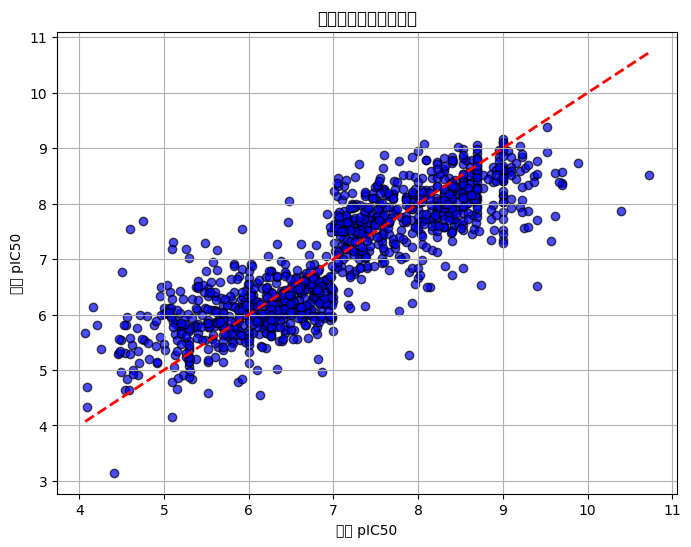

外部验证集预测完成，并保存了结果（包含适用域评估、回归报告和散点图）！


In [30]:
from sklearn.neural_network import etrRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
# 10. 外部验证集回归报告与散点图
# -------------------------
if "pIC50" in external_data.columns:
    y_true = external_data["pIC50"]
    y_pred_ext = external_predictions
    mse_ext = mean_squared_error(y_true, y_pred_ext)
    r2_ext = r2_score(y_true, y_pred_ext)
    mae_ext = mean_absolute_error(y_true, y_pred_ext)
    
    print("外部验证集回归报告：")
    print(f"MSE: {mse_ext}")
    print(f"MAE: {mae_ext}")
    print(f"R2: {r2_ext}")
    
    # 绘制散点图
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred_ext, c='blue', marker='o', edgecolor='k', alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("真实 pIC50")
    plt.ylabel("预测 pIC50")
    plt.title("外部验证集回归散点图")
    plt.grid(True)
    plt.savefig("external_regression_scatter.png")
    plt.show()
else:
    print("外部验证集中没有真实的 pIC50 值，无法生成回归报告。")

print("外部验证集预测完成，并保存了结果（包含适用域评估、回归报告和散点图）！")